# План и вопросы

2. `Анализ риск-факторов`
    - Основные пункты
        1. Динамика факторов
        2. Компоненты ряда, стационарность
        3. Распределение для изменений
        4. Корреляции
    - Вопросы
        1.  Что делать с +- месячной паузой в 2022? Есть предложение взять 2023-2024 года только, например.
        2.  Выходные будем выкидывать?
        3.  Какие еще факторы будем смотреть?
        4.  Как будем анализировать много активов, разбивать на классы и за день брать среднее изменение?
3. `Стохастическая модель динамики`
    - Основные пункты
        1. Описание модели для каждого риск-фактора
        2. Реализация модели
        3. Оценка параметров методом максимального правдоподобия
    - Вопросы
        1.  Что за стохастическая модель динамики? Это типо Brownian motion или ARIMA? Судя по пункту 5 будто скорее первое, хотя можно же типо аримой предиктить и далее добавлять шум самим.
4. `Оценка справедливой стоимости активов в зависимости от риск-факторов`
    - Основные пункты
        1. Реализация оценки
        2. Проверка точности 
    - Вопросы
        1. Как? Типо просто построим линрег и будем предиктить разницу?
5. `Оценка на горизонте 1 и 10 дней 2 декабря`
    - Основные пункты (делаем их так, чтобы можно было запускать на любой день, т.е. это должна быть функция)
        1. Генерим выборку значений риск-факторов (см. пункт 3)
        2. На основе выборки риск-факторов получаем набор оценок портфеля (см. пункт 4), считая, что ребалансировка идет каждый день
        3. Оцениваем VAR и ES
6. `Backtesting`
    - Основные пункты
        1. Повторяем пункт 5, прогоняя для каждого дня 2024-го года и делая сравнение реальности и предсказания, чтобы считать, вышли ли мы за границы VAR
        2. Полученную оценку сравниваем с ожидаемой -> делаем вывод о корректности.
7. `Backtesting оценка с использованием тестов`
    - Основные пункты
        1. Берем результаты пункта 6 и засовываем в тест

## Источники

- [`investing.com`](https://ru.investing.com/) - котировки акций и индексов
- [`cbr.ru`](https://www.cbr.ru/) - курсы валют
- [`cbonds.ru`](https://cbonds.ru/) - ставки на разные промежутки, котировки облигаций и даты выплаты купонов
- [`dohod.ru`](https://www.dohod.ru/) - списки облигаций

Собрать данные.
1. ~~Процентные ставки на разные сроки (от 0 до 30 лет) за период с 1 января 2021 г. по 1 января 2025 г.~~
2. ~~Описания 5 государственных облигаций РФ (расписания выплат). Критерии — государственные облигации с полностью известными размерами выплат (не привязанные к показателям), без оферт, со сроком погашения после 1 января 2025 г.:~~
3. ~~Рыночные котировки этих облигаций за период с 1 января 2021 г. по 1 января 2025 г~~.
4. ~~Котировки 10 российских акций за тот же период.~~
5. ~~Значения индекса МосБиржи, индекса РТС, цены на нефть Brent и курса доллара и евро за тот же период.~~
6. Котировки фьючерса и опционов на фьючерс на один выбранный актив из предыдущего пункта — выбрать один торговый день за 2024 год. Срок погашения и фьючерса, и опционов взять ближайшие к выбранному дню, но не ближе, чем 1 месяц. Опционы и Put, и Call — только для бонусного задания.

In [136]:
path_data = 'data/'
start = '2021-01-01'
end = '2025-01-01'

In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import plotly.graph_objects as go

pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', None)


In [3]:
def make_ax_better(ax, locators=()):
    """
        Функция добавляет сетку, убирает края и делает minor ticks
    """
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if 'x' in locators:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
    if 'y' in locators:
        ax.yaxis.set_minor_locator(AutoMinorLocator())
    if locators:
        ax.tick_params(which='minor', length=2.5)
        ax.tick_params(which='major', length=5)
        ax.grid(which='minor', linewidth=0.15, color='tab:grey', alpha=0.3)
    ax.grid(linewidth=0.5, color='tab:grey', alpha=0.3)
    ax.set_axisbelow(True)

def make_str_bold(s):
    """
        Функция для выделения строки жирным для print
    """
    return '\033[1m' + str(s) + '\033[0m'

colors = [
    '#42CAFD', '#FF751F', '#8DD65C', '#FF495C',
    '#D68FD6', 
    '#FFCB47',
    '#DACC3E', '#CC5A71', '#A44200',
    '#42CAFD', '#FF751F', '#8DD65C', '#FF495C',
    '#42CAFD', '#D68FD6', '#FFCB47',
] * 10


def plot_ts_plotly(
    df: pd.DataFrame,
    x: str,
    y: list[str],
    palette: list[str] = colors,
    title: str = None,
    xaxis_title: str = 'Дата',
    yaxis_title: str = '% от цены покупки',
    fig_size: tuple[int, int] = (1100, 550),  # Размер фигуры (ширина, высота)
):
    # Создаем фигуру
    fig = go.Figure()
        
    # Добавляем линии для каждого столбца в DataFrame
    for col, color in zip(y, palette):
        fig.add_trace(
            go.Scatter(
                x=df[x],
                y=df[col],
                mode='lines',
                name=col,
                line=dict(color=color),
                hovertemplate=f'<b>{col}</b>: %{{y:.1f}}%<extra></extra>'
            )
        )

    # Настраиваем заголовок и оси
    fig.update_layout(
        title={
            'text': title,
            'y': 0.95,  # Позиция заголовка по вертикали
            'x': 0.5,    # Позиция заголовка по горизонтали (центр)
            'xanchor': 'center',  # Центрируем заголовок
            'yanchor': 'top',     # Привязка к верхней части
            'font': dict(size=22)  # Размер шрифта заголовка
        },
        xaxis_title=xaxis_title,
        yaxis_title=yaxis_title,
        template='plotly_white',
        legend=dict(
            x=0.5,  # Центрируем легенду по горизонтали
            y=-0.2,  # Размещаем легенду ниже графика
            xanchor='center',  # Привязка к центру
            yanchor='top',     # Привязка к верхней части
            orientation='h',  # Горизонтальная ориентация
            font=dict(size=12),  # Размер шрифта легенды
            traceorder='normal',  # Порядок элементов легенды
            itemwidth=50,  # Ширина элемента легенды
            itemsizing='constant',  # Фиксированный размер элементов
            bordercolor='lightgray',  # Цвет границы легенды
            borderwidth=1,  # Ширина границы легенды
            bgcolor='rgba(255, 255, 255, 0.8)',  # Цвет фона легенды
            # columns=legend_cols  # Количество столбцов в легенде
        ),
        hovermode='x unified',
        width=fig_size[0],  # Ширина фигуры
        height=fig_size[1],  # Высота фигуры
        margin=dict(l=50, r=50, b=50, t=100)  # Отступы (left, right, bottom, top)
    )

    # Настраиваем оси
    fig.update_xaxes(
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray',
        minor=dict(
            ticklen=4,  # Длина minor-тиков
            tickcolor='gray',  # Цвет minor-тиков
            showgrid=True,  # Показываем minor-сетку
            gridcolor='rgba(211, 211, 211, 0.5)',  # Цвет minor-сетки (светло-серый с прозрачностью)
            griddash='dot'  # Стиль minor-сетки (точечный)
        )
    )
    fig.update_yaxes(
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray',
        minor=dict(
            ticklen=4,  # Длина minor-тиков
            tickcolor='gray',  # Цвет minor-тиков
            showgrid=True,  # Показываем minor-сетку
            gridcolor='rgba(211, 211, 211, 0.5)',  # Цвет minor-сетки (светло-серый с прозрачностью)
            griddash='dot'  # Стиль minor-сетки (точечный)
        )
    )

    # Показываем график
    fig.show()

# Загрузка данных

## Акции

In [4]:
share_names = [
    'SBER',
    'YDEX',
    'ROSN',
    'PLZL',
    'LKOH',
    'GAZP',
    'NVTK',
    'MOEX',
    'CHMF',
    'GMKN'
]

In [138]:
stocks = []
for ticker in share_names:
    filepath = path_data + ticker + '.csv'
    cur_df = pd.read_csv(filepath, usecols=['Дата', 'Цена']).drop_duplicates()
    cur_df['Дата'] = pd.to_datetime(cur_df['Дата'], format='%d.%m.%Y')
    cur_df['Цена'] = cur_df['Цена'].astype(str).str.rstrip('.0').str.replace('.', '').str.replace(',', '.').astype(float)
    n_duplicates = cur_df.shape[0] - cur_df['Дата'].nunique()
    if n_duplicates:
        print(filepath, f'число дубликатов: {n_duplicates}, усредняем цены за дублирующиеся даты')
        cur_df = cur_df.groupby(['Дата'], as_index=False)['Цена'].mean()
    cur_df = cur_df.set_index('Дата').rename(columns={'Цена': ticker})
    stocks.append(cur_df)
stocks = pd.concat(stocks, axis=1) 
print(stocks.shape)
stocks = stocks[
    (stocks.index >= pd.Timestamp(start))
    & (stocks.index < pd.Timestamp(end))
]
stocks.tail()

data/SBER.csv число дубликатов: 3, усредняем цены за дублирующиеся даты
data/GAZP.csv число дубликатов: 2, усредняем цены за дублирующиеся даты
(1000, 10)


,SBER,YDEX,ROSN,PLZL,LKOH,GAZP,NVTK,MOEX,CHMF,GMKN
Дата,,,,,,,,,,
2024-12-25,271.69,3790.0,581.95,13973.5,6987.5,128.11,929.4,196.61,1161.8,108.0
2024-12-26,269.56,3785.0,579.10,14001.0,7003.0,126.89,949.8,194.08,1174.4,109.7
2024-12-27,271.20,3848.0,591.00,14139.0,6990.5,127.79,949.2,192.45,1186.2,111.0
2024-12-28,272.83,3928.5,596.00,13926.0,6998.0,129.60,951.8,192.61,1232.2,113.8
2024-12-30,279.43,3994.0,606.05,13981.0,7235.0,133.12,996.0,199.22,1337.4,115.5


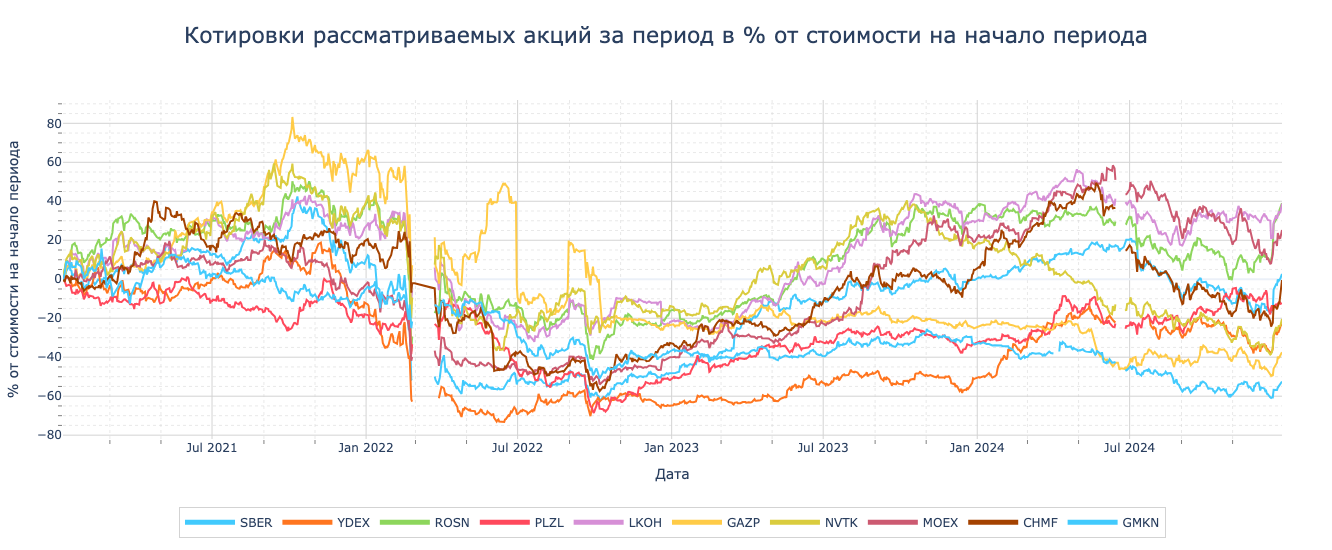

In [139]:
df = data.copy()
df = (df / df.iloc[0] - 1) * 100

cols_to_show = ['1W', '1M', '1Y', '5Y', '10Y', '30Y']
plot_ts_plotly(
    df.reset_index(),
    x='Дата',
    y=df.columns,
    title='Котировки рассматриваемых акций за период в % от стоимости на начало периода',
    xaxis_title='Дата',
    yaxis_title='% от стоимости на начало периода'
    
)

## Ставки

In [142]:
rates = pd.read_excel(path_data + 'rates.xlsx')
rates['Дата'] = pd.to_datetime(rates['Дата'], format='%d.%m.%Y')
rates = (
    rates
    .rename(columns={
        col: col.split()[-1] for col in rates.columns[1:]
    })
    .set_index('Дата')
    .drop(columns=['РФ'])
)
rates = rates[
    (rates.index >= pd.Timestamp(start))
    & (rates.index < pd.Timestamp(end))
]
rates.tail()

,10Y,15Y,20Y,25Y,30Y,1Y,2Y,3Y,5Y,7Y,4Y,8Y,9Y,1W,2W,1M,2M,3M,4M,9M,6M
Дата,,,,,,,,,,,,,,,,,,,,,
2024-12-25,15.213742,14.521210,14.145825,13.934819,13.797494,18.242530,17.883281,17.435424,16.576328,15.906219,16.986744,15.640223,15.411741,18.296215,18.300210,18.308390,18.320274,18.328108,18.331479,18.296699,18.327275
2024-12-26,15.284621,14.619945,14.264667,14.067818,13.939545,17.956649,17.702504,17.333252,16.570249,15.946337,16.941230,15.693652,15.474962,17.919402,17.924830,17.936325,17.954585,17.969307,17.979261,17.984134,17.990260
2024-12-27,15.430508,14.747656,14.363036,14.137707,13.990107,17.669109,17.561862,17.292200,16.649654,16.078685,16.970190,15.835069,15.620094,17.355953,17.368659,17.396492,17.444275,17.488220,17.523689,17.643571,17.585694
2024-12-28,15.566986,14.916261,14.550008,14.337680,14.200138,18.525025,18.151565,17.671248,16.828921,16.210946,17.217608,15.964092,15.751326,18.486078,18.493498,18.509232,18.534271,18.554448,18.567988,18.569813,18.582141
2024-12-30,15.222626,14.573456,14.220410,14.024297,13.897065,18.581608,18.055996,17.481006,16.533707,15.873952,16.964345,15.620923,15.406795,18.802057,18.803098,18.804450,18.803235,18.797023,18.787161,18.679350,18.753506


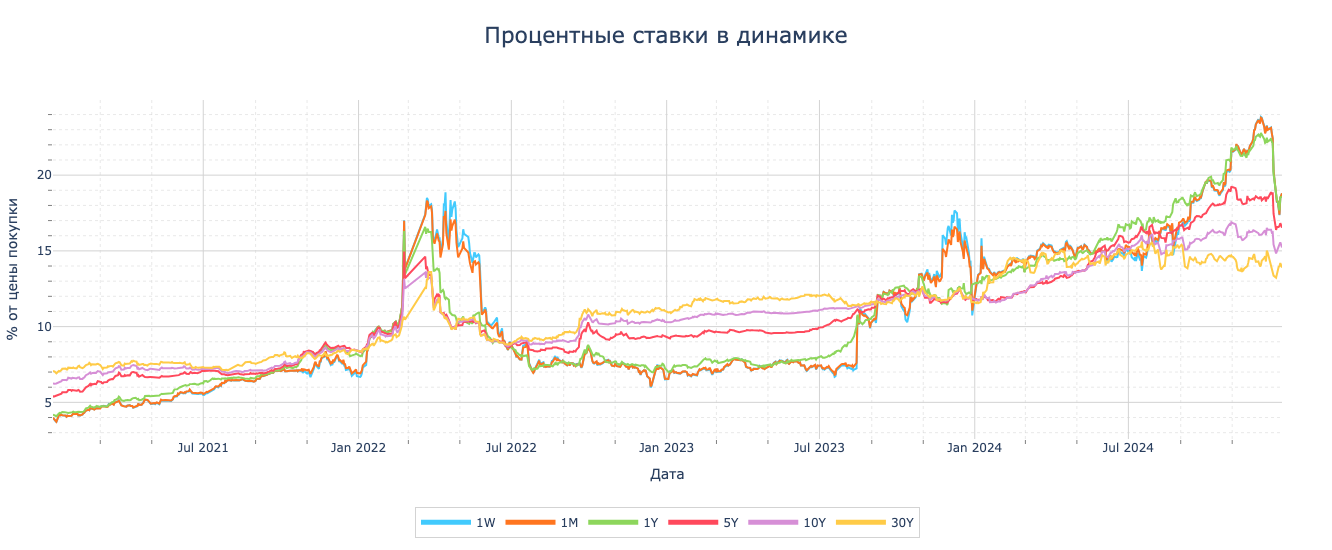

In [143]:
cols_to_show = ['1W', '1M', '1Y', '5Y', '10Y', '30Y']
plot_ts_plotly(
    rates.reset_index(),
    x='Дата',
    y=cols_to_show,
    title='Процентные ставки в динамике'
)

## Котировки облигаций

In [144]:
coupons = []
bonds = []

bonds_path = path_data + '/bonds/'
for filename in os.listdir(bonds_path):
    if not filename.startswith('~') and filename != '.DS_Store':
        series, isin, file_type = filename.split('_')
        file_type = file_type.split('.')[0]
        if file_type == 'coupons':
            file = pd.read_excel(bonds_path + filename, skiprows=2)
            file['ISIN'] = isin
            coupons.append(file)
        elif file_type == 'price':
            file = pd.read_excel(bonds_path + filename, skiprows=1)
            bonds.append(file)
        else:
            raise ValueError('Unknow file type')
bonds = pd.concat(bonds)
bonds['Дата'] = pd.to_datetime(pd.to_datetime(bonds['Дата']).dt.date)
bonds = bonds.set_index('Дата')
bonds = bonds[
    (bonds.index >= pd.Timestamp(start))
    & (bonds.index < pd.Timestamp(end))
]
bond_prices = pd.pivot(
    bonds.reset_index(),
    index='Дата',
    values='Indicative',
    columns=['ISIN']
) * 1000 / 100
coupons = pd.concat(coupons)
display(bonds.head())
display(coupons.head())

,Биржа,Bid,Ask,Indicative,YTM Bid,YTM Ask,YTM Indicative,Оборот,G-spread,ISIN,Рег. номер
Дата,,,,,,,,,,,
2024-12-30,Московская биржа Т+,63.013,63.119,62.865,15.9424,15.9034,15.9970,3919643.55,-59.173832,RU000A1028E3,26235RMFS
2024-12-28,Московская биржа Т+,62.953,63.060,62.971,15.9570,15.9176,15.9504,6701952.44,-92.618243,RU000A1028E3,26235RMFS
2024-12-27,Московская биржа Т+,62.440,62.505,62.445,16.1438,16.1196,16.1419,6454900.96,-55.015087,RU000A1028E3,26235RMFS
2024-12-26,Московская биржа Т+,62.479,62.500,62.122,16.1254,16.1176,16.2589,30593060.19,-36.020267,RU000A1028E3,26235RMFS
2024-12-25,Московская биржа Т+,61.744,61.890,61.915,16.3973,16.3422,16.3328,14176578.70,-29.689735,RU000A1028E3,26235RMFS


,№,Окончание купона,Фактическая выплата,Фиксация списка держателей,"Купон, %",Сумма купона RUB,Погашение RUB,ISIN
0,1,2021-03-24,2021-03-24,2021-03-23,5.9,26.02,NaN,RU000A1028E3
1,2,2021-09-22,2021-09-22,2021-09-21,5.9,29.42,NaN,RU000A1028E3
2,3,2022-03-23,2022-03-23,2022-03-22,5.9,29.42,NaN,RU000A1028E3
3,4,2022-09-21,2022-09-21,2022-09-20,5.9,29.42,NaN,RU000A1028E3
4,5,2023-03-22,2023-03-22,2023-03-21,5.9,29.42,NaN,RU000A1028E3


## Курсы валют, индексы, нефть, золото

In [145]:
# Курсы цб 
usdrub = pd.read_csv(path_data + 'usd.csv')
eurrub = pd.read_csv(path_data + 'eur.csv')
# Инвестинг
imoex = pd.read_csv(path_data + 'IMOEX.csv')
irts = pd.read_csv(path_data + 'IRTS.csv')
brent = pd.read_csv(path_data + 'brent.csv')
gold = pd.read_csv(path_data + 'gold.csv')

df_index = []
for df, name in zip([usdrub, eurrub], ['usd', 'eur']):
    df = df.rename(columns={'data': 'Дата', 'curs': name})
    df['Дата'] = pd.to_datetime(df['Дата'])
    df_index.append(df.set_index('Дата')[[name]])

for df, name in zip([imoex, irts, brent, gold], ['imoex', 'irts', 'brent', 'gold']):
    df['Дата'] = pd.to_datetime(df['Дата'], format='%d.%m.%Y')
    df['Цена'] = (
        df['Цена']
        .astype(str)
        .str.rstrip('.0')
        .str.replace('.', '')
        .str.replace(',', '.')
        .astype(float)
    )
    df = (
        df
        .rename(columns={'Цена': name})
        .set_index('Дата')
        [[name]]
    )
    df_index.append(df)
df_index = pd.concat(df_index, axis=1)
df_index = df_index[
    (df_index.index >= pd.Timestamp(start))
    & (df_index.index < pd.Timestamp(end))
]
df_index = df_index.ffill().bfill()
df_index.head()

,usd,eur,imoex,irts,brent,gold
Дата,,,,,,
2021-01-01,73.8757,90.7932,3350.51,1424.84,51.09,1898.10
2021-01-04,73.8757,90.7932,3350.51,1424.84,51.09,1942.28
2021-01-05,73.8757,90.7932,3359.15,1426.11,53.60,1949.35
2021-01-06,73.8757,90.7932,3371.03,1436.71,54.30,1918.81
2021-01-07,73.8757,90.7932,3371.03,1436.71,54.38,1912.50


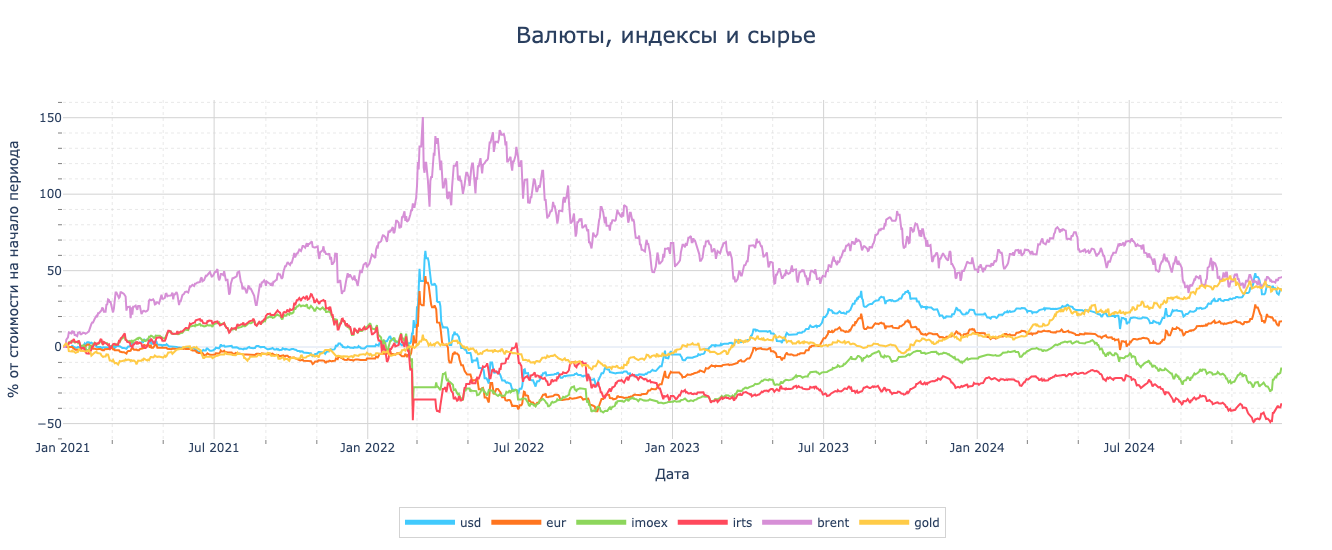

In [146]:
df = df_index.copy()
df = (df / df.iloc[0] - 1) * 100

cols_to_show = ['1W', '1M', '1Y', '5Y', '10Y', '30Y']
plot_ts_plotly(
    df.reset_index(),
    x='Дата',
    y=df.columns,
    title='Валюты, индексы и сырье',
    xaxis_title='Дата',
    yaxis_title='% от стоимости на начало периода'
    
)

# 1. Риск факторы

1. Процентные ставки — влияют на стоимость облигаций и стоимость заимствования компаний.
2. Котировки акций — сами по себе являются риск-факторами.
3. Курсы валют (USD/RUB, EUR/RUB) — влияют на валютные позиции.
4. Цена нефти — влияет на нефтегазовый сектор, золото - на акции золотодобытчиков.
5. Индекс Мосбиржи — может использоваться как обобщённый рыночный фактор.



In [147]:
all_data = pd.concat([
    df_index.pct_change(),
    rates.diff(),
    stocks.pct_change(fill_method=None),
    bond_prices.pct_change(),
], axis=1)
all_data.shape

(1245, 42)

In [148]:
all_data.corr()

,usd,eur,imoex,irts,brent,gold,10Y,15Y,20Y,25Y,30Y,1Y,2Y,3Y,5Y,7Y,4Y,8Y,9Y,1W,2W,1M,2M,3M,4M,9M,6M,SBER,YDEX,ROSN,PLZL,LKOH,GAZP,NVTK,MOEX,CHMF,GMKN,RU000A0JS3W6,RU000A0ZYUA9,RU000A100EF5,RU000A101QE0,RU000A1028E3
usd,1.000000,0.941459,0.070256,0.009024,0.039733,0.004268,0.058392,0.089034,0.091508,0.085917,0.079648,0.010446,0.024979,0.024582,0.018189,0.026039,0.020396,0.035647,0.047057,0.017901,0.016839,0.017225,0.013283,0.009877,0.007579,0.006478,0.005252,-0.007891,-0.016111,0.046122,0.030554,0.027479,0.077582,0.065789,-0.003296,0.019375,0.012080,-0.064974,-0.031232,-0.000724,-0.108352,-0.086315
eur,0.941459,1.000000,0.060817,0.006814,0.040724,-0.003698,0.078328,0.104199,0.102165,0.094423,0.086825,0.028204,0.039419,0.037348,0.033365,0.044613,0.033784,0.055208,0.067064,0.037671,0.036654,0.036161,0.032100,0.028490,0.026005,0.024518,0.023425,-0.018025,-0.023257,0.050268,0.034653,0.013157,0.080681,0.041641,0.007970,0.027832,0.010780,-0.065911,-0.046038,-0.005491,-0.112152,-0.089290
imoex,0.070256,0.060817,1.000000,0.840299,0.054639,0.046873,-0.558154,-0.406448,-0.304029,-0.247558,-0.211410,-0.556275,-0.582529,-0.604539,-0.628930,-0.625964,-0.619124,-0.611012,-0.587665,-0.376745,-0.388707,-0.414294,-0.453825,-0.483518,-0.502432,-0.544768,-0.526705,0.789742,0.655893,0.796637,0.549078,0.719367,0.704699,0.693293,0.634335,0.618036,0.621278,0.547158,0.594210,0.490422,0.413703,0.376245
irts,0.009024,0.006814,0.840299,1.000000,0.073937,0.062742,-0.528014,-0.389645,-0.295137,-0.242114,-0.208308,-0.534948,-0.565429,-0.582975,-0.597574,-0.591027,-0.591910,-0.576618,-0.555013,-0.349712,-0.361430,-0.384526,-0.423738,-0.453840,-0.473536,-0.521010,-0.499970,0.689440,0.534655,0.656758,0.446175,0.572707,0.593598,0.590516,0.525725,0.519574,0.507027,0.506297,0.561275,0.454812,0.375728,0.355411
brent,0.039733,0.040724,0.054639,0.073937,1.000000,0.194437,0.052809,0.045905,0.044621,0.046546,0.048836,0.063121,0.062169,0.061927,0.060264,0.057717,0.061441,0.056341,0.054683,0.051849,0.053243,0.056337,0.060596,0.063349,0.064662,0.064026,0.065158,0.041301,0.025383,0.129639,0.049099,0.134544,0.061960,0.112402,0.040645,0.072291,0.070627,-0.061427,-0.045549,-0.054068,-0.027509,-0.044164
gold,0.004268,-0.003698,0.046873,0.062742,0.194437,1.000000,-0.006423,-0.011861,-0.015505,-0.016868,-0.017354,0.008228,0.001268,-0.007315,-0.008979,-0.005781,-0.010040,-0.005493,-0.005783,-0.027228,-0.026268,-0.024943,-0.019747,-0.014088,-0.009241,0.005758,-0.000970,0.037533,0.083409,0.042371,0.355696,0.030292,0.046781,0.032368,0.011917,0.027728,0.061003,0.026409,0.014171,-0.000230,0.045517,0.012514
10Y,0.058392,0.078328,-0.558154,-0.528014,0.052809,-0.006423,1.000000,0.915440,0.798511,0.718080,0.661583,0.692557,0.756763,0.814793,0.895697,0.954619,0.859214,0.978359,0.994484,0.470717,0.485484,0.513196,0.561259,0.597154,0.619944,0.673673,0.649510,-0.477456,-0.419334,-0.536864,-0.311527,-0.375886,-0.341548,-0.404271,-0.353612,-0.332104,-0.334397,-0.769840,-0.795775,-0.739958,-0.656861,-0.702717
15Y,0.089034,0.104199,-0.406448,-0.389645,0.045905,-0.011861,0.915440,1.000000,0.970029,0.926146,0.887097,0.568935,0.601580,0.627059,0.685089,0.768892,0.653306,0.820182,0.871122,0.364665,0.377759,0.400225,0.444217,0.478366,0.500899,0.554342,0.531133,-0.384903,-0.335695,-0.422587,-0.235966,-0.293646,-0.265222,-0.299463,-0.291244,-0.281005,-0.277726,-0.628069,-0.643425,-0.644627,-0.598488,-0.638738
20Y,0.091508,0.102165,-0.304029,-0.295137,0.044621,-0.015505,0.798511,0.970029,1.000000,0.988858,0.969053,0.480995,0.495291,0.500164,0.535027,0.618235,0.511772,0.676748,0.739214,0.297158,0.308735,0.327870,0.367444,0.398749,0.419764,0.469452,0.448319,-0.300257,-0.258189,-0.332755,-0.177990,-0.230345,-0.207192,-0.221674,-0.235486,-0.232075,-0.226311,-0.518352,-0.527919,-0.564235,-0.529493,-0.563231
25Y,0.085917,0.094423,-0.247558,-0.242114,0.046546,-0.016868,0.718080,0.926146,0.988858,1.000000,0.994814,0.430128,0.434753,0.428523,0.449949,0.529336,0.431931,0.588798,0.654101,0.261172,0.271747,0.289061,

Упростим матрицу и оставим средние изменения по классам активов

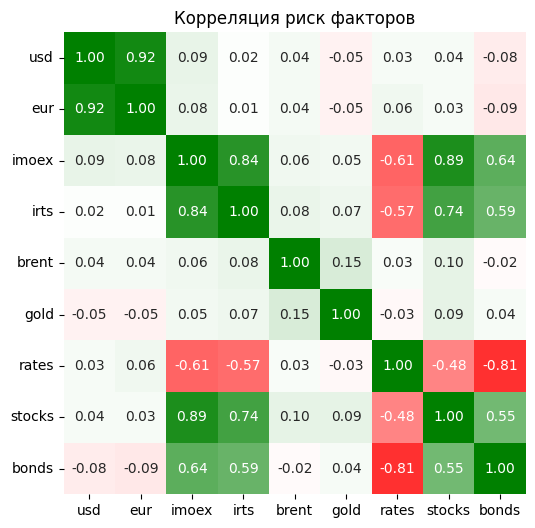

In [158]:
from  matplotlib.colors import LinearSegmentedColormap

simplified_all_data = pd.concat([
    df_index.pct_change() * 100,
    rates.diff().mean(axis=1).rename('rates'),
    stocks.pct_change(fill_method=None).mean(axis=1).rename('stocks') * 100,
    bond_prices.pct_change().mean(axis=1).rename('bonds') * 100,
], axis=1).dropna()
simplified_all_data.shape
corr_matrix = simplified_all_data.corr()

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    square=True,
    cbar=False,
    cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256),
    vmin=-1,
    vmax=1
)
ax.tick_params(rotation=0)
ax.set_title('Корреляция риск факторов')
plt.show()

Объясненная дисперсия: [0.41158249 0.21769335 0.13010142 0.09439583]
В сумме: 0.8537730984446621
Веса компонент в новых координатах


,PC1,PC2,PC3,PC4
usd,-0.007673,0.696177,0.028701,-0.085635
eur,-0.001223,0.697150,0.025842,-0.079524
imoex,-0.483965,0.075148,-0.019044,0.078833
irts,-0.456814,0.018834,-0.045444,0.088517
brent,-0.035952,0.062335,-0.704664,0.610514
gold,-0.047714,-0.058297,-0.662319,-0.744165
rates,0.412513,0.069973,-0.170738,0.145336
stocks,-0.447060,0.043458,-0.102922,0.103491
bonds,-0.428298,-0.096172,0.145320,-0.118118


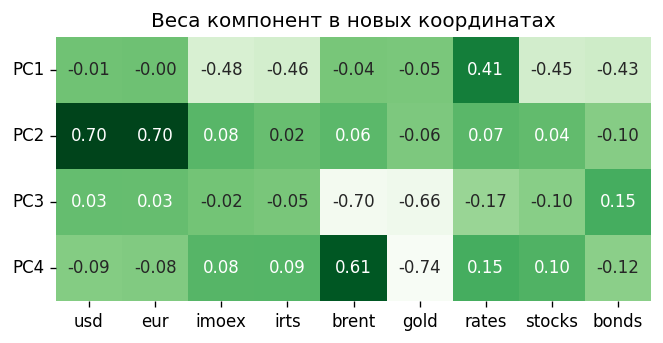

In [180]:
# Нормализуем данные
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(simplified_all_data)

# Применяем PCA
pca = PCA(n_components=4)
pca_result = pca.fit_transform(scaled_data)

pca_components = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i}' for i in range(1, pca.components_.shape[0] + 1)],
    index=simplified_all_data.columns
)

print("Объясненная дисперсия:", pca.explained_variance_ratio_)
print('В сумме:', pca.explained_variance_ratio_.sum())
print('Веса компонент в новых координатах')
display(pca_components)
fig, ax = plt.subplots(dpi=120)
sns.heatmap(
    pca_components.T,
    annot=True,
    fmt='.2f',
    square=True,
    cbar=False,
    cmap='Greens',
)
ax.tick_params(rotation=0)
ax.set_title('Веса компонент в новых координатах')
plt.show()

TODO описать группы рисков?

<!-- Исходя из анализа весов факторов в новых компонентах можно выделить 3 группы рисков:
- ***Рыночный риск*** (55% дисперсии): наиболее сильно влияют индекс МосБиржи, РТС и выбранные нами акции
- ***Товарно-сырьевой риск*** (20.6% дисперсии): цены на нефть
- ***Валютный риск*** (11.7%) дисперсии: курс доллара и евро -->

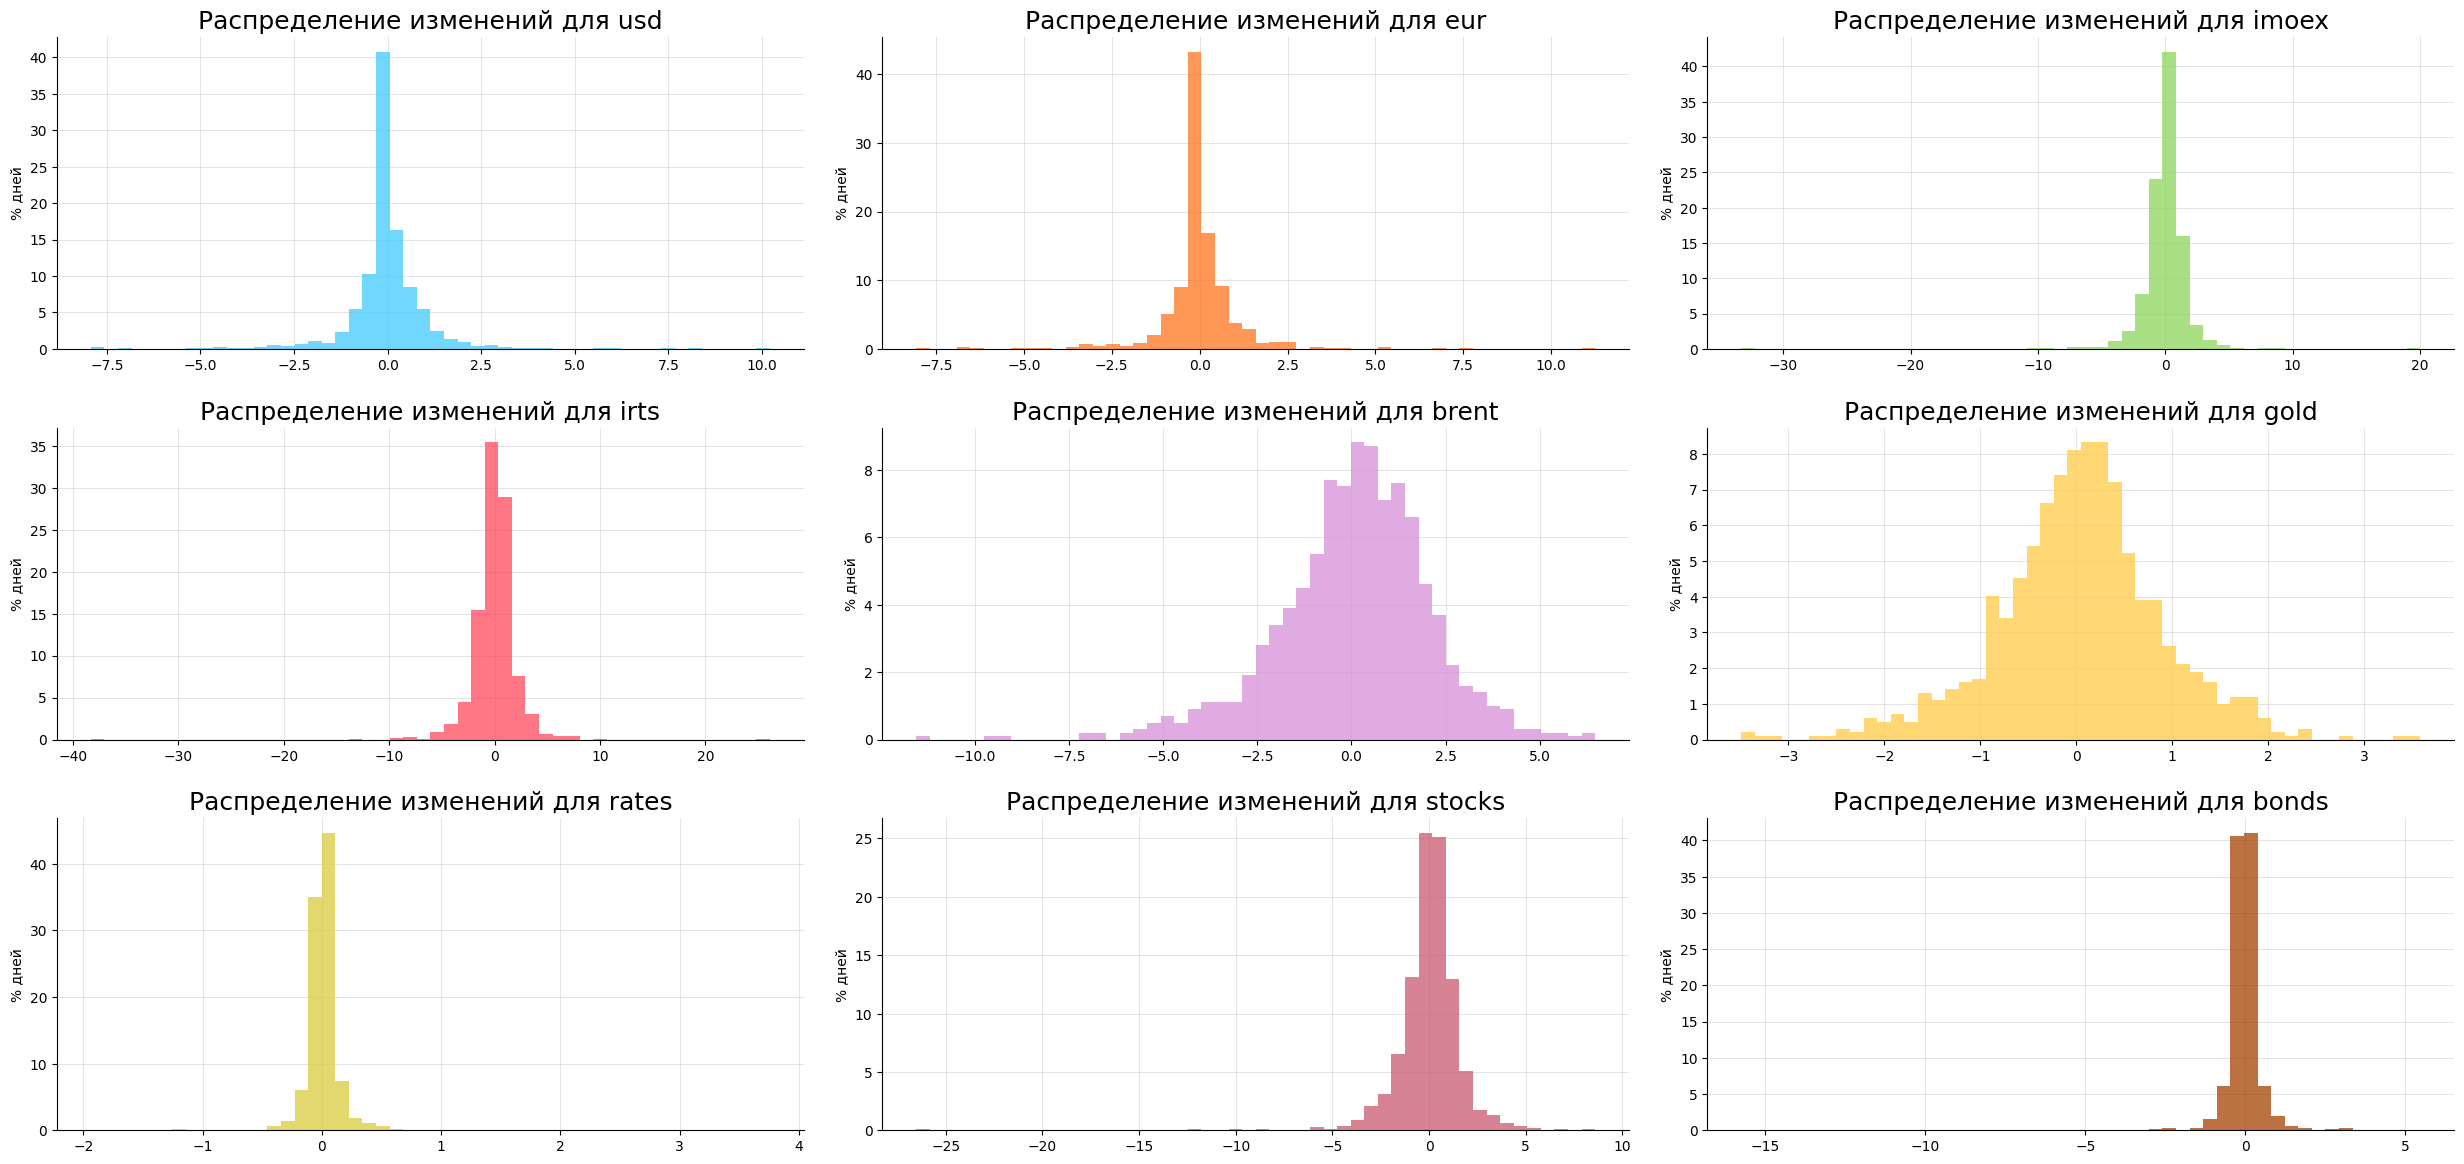

In [181]:
fig, axes = plt.subplots(figsize=(25, 12), ncols=3, nrows=3)
for ax, col, color in zip(axes.flatten(), simplified_all_data, colors*20):
    sns.histplot(
        simplified_all_data[col],
        color=color,
        ax=ax,
        bins=50,
        edgecolor='none',
        stat='percent'
    )
    ax.set_title(
        f'Распределение изменений для {col}',
        fontsize=18
    )
    ax.set_xlabel('')
    ax.set_ylabel('% дней')
    make_ax_better(ax)
plt.tight_layout(pad=2)